# (Impact of different number of layers, different activation functions and optimization on learning): 
The code logistic_regression_multi_layer.ipynb is a 2-layer logistic regression. The goal is to extend it to 4- & 6-layer logistic regression with different neurons and activation function for each layer utilizing different optimization routine to assess their impact on accuracy.
- (5) 6 layers all leaky ReLU
- In all those cases, what is the exact number of parameters we are trying to learn? Assess and conclude
- 784$\times$50 + 50 + 50$\times$50 + 50 + 50$\times$50 + 50 + 50$\times$50 + 50 + 50$\times$50 + 50 + 50$\times$10 + 10 = 49960

In [1]:
import tensorflow.compat.v1 as tf
import time
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
tf.disable_v2_behavior()

#load MNIST dataset 
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [2]:
# Global Parameters
learning_rate = 0.05
training_epochs = 100
batch_size = 50
display_step = 10

#Network Architecture
# -----------------------------------------
# Five hidden layers
# ------------------------------------------
# number of neurons in layer 1
n_hidden_1 = 50
# number of neurons in layer 2
n_hidden_2 = 50
# number of neurons in layer 3
n_hidden_3 = 50
# number of neurons in layer 4
n_hidden_4 = 50
# number of neurons in layer 5
n_hidden_5 = 50

#MNIST data image of shape 28*28=784
input_size = 784

# 0-9 digits recognition (labels)
output_size = 10

In [3]:
def layer(x, weight_shape, bias_shape):
    """
    Defines the network layers
    input:
        - x: input vector of the layer
        - weight_shape: shape of the weight maxtrix
        - bias_shape: shape of the bias vector
    output:
        - output vector of the layer after the matrix multiplication and non linear transformation
    """
    # comes from the study by He et al. for ReLU layers
    w_std = (2.0/weight_shape[0])**0.5
    #print(weight_shape[0])
    #w_std = 0.5;

    #initialization of the weights
    #you can try either
    w_0 = tf.random_normal_initializer(stddev=w_std)
    #w_0 = tf.random_uniform_initializer(minval=-1,maxval=1)

    b_0 = tf.constant_initializer(value=0)
    
    W = tf.get_variable("W", weight_shape, initializer=w_0)
    b = tf.get_variable("b", bias_shape,   initializer=b_0)
    
    #print('Weight Matrix:', W)
    #print('Bias Vector:', b)
    # sigmoid activation
    return tf.nn.leaky_relu(tf.matmul(x, W) + b)

In [4]:
def inference(x):
    """
    define the whole network (5 hidden layers + output layers)
    input:
        - a batch of pictures 
        (input shape = (batch_size*image_size))
    output:
        - a batch vector corresponding to the logits predicted by the network
        (output shape = (batch_size*output_size)) 
    """
    
    with tf.variable_scope("hidden_layer_1"):
        hidden_1 = layer(x, [input_size, n_hidden_1], [n_hidden_1])
        print([input_size, n_hidden_1])
     
    with tf.variable_scope("hidden_layer_2"):
        hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2])
        print([n_hidden_1, n_hidden_2])

    with tf.variable_scope("hidden_layer_3"):
        hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3])
        print([n_hidden_2, n_hidden_3])
        
    with tf.variable_scope("hidden_layer_4"):
        hidden_4 = layer(hidden_3, [n_hidden_3, n_hidden_4], [n_hidden_4])
        print([n_hidden_3, n_hidden_4])

    with tf.variable_scope("hidden_layer_5"):
        hidden_5 = layer(hidden_4, [n_hidden_4, n_hidden_5], [n_hidden_5])
        print([n_hidden_4, n_hidden_5])
     
    with tf.variable_scope("output"):
        output = layer(hidden_5, [n_hidden_5, output_size], [output_size])
        print([n_hidden_5, output_size])

    return output

In [5]:
def loss_1(output, y):
    """
    computes the average error per data sample 
    by computing the cross-entropy loss over a minibatch
    intput:
        - output: the output of the inference function 
        - y: true value of the sample batch
        
        the two have the same shape (batch_size * num_of_classes)
    output:
        - loss: loss of the corresponding batch (scalar tensor)
    
    """
    dot_product = y * tf.log(output)
    
    #tf.reduce_sum: Computes the sum of elements across dimensions of a tensor.
    xentropy = -tf.reduce_sum(dot_product, 1)
    
    #tf.reduce_mean: Computes the mean of elements across dimensions of a tensor.
    loss = tf.reduce_mean(xentropy)

    return loss

def loss_2(output, y):
    """
    Computes softmax cross entropy between logits and labels and then the loss 
    
    intput:
        - output: the output of the inference function 
        - y: true value of the sample batch
        
        the two have the same shape (batch_size * num_of_classes)
    output:
        - loss: loss of the corresponding batch (scalar tensor)
    
    """

    #mean square error
    #loss = tf.reduce_mean(tf.reduce_sum(tf.square(y-output)))
    
    #Computes softmax cross entropy between logits and labels.
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)

    return loss

In [6]:
def training(cost, global_step):
    """
    defines the necessary elements to train the network
    
    intput:
        - cost: the cost is the loss of the corresponding batch
        - global_step: number of batch seen so far, it is incremented by one 
        each time the .minimize() function is called
    """
    tf.summary.scalar("cost", cost)
    # tf.train.AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, global_step=global_step)

    return train_op

In [7]:
def evaluate(output, y):
    """
    evaluates the accuracy on the validation set 
    input:
        -output: prediction vector of the network for the validation set
        -y: true value for the validation set
    output:
        - accuracy: accuracy on the validation set (scalar between 0 and 1)
    """
    #correct prediction is a binary vector which equals one when the output and y match
    #otherwise the vector equals 0
    #tf.cast: change the type of a tensor into another one (改变张量数据类型的转换函数)
    #then, by taking the mean of the tensor, we directly have the average score, so the accuracy
    
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tf.summary.scalar("validation_error", (1.0 - accuracy))

    return accuracy

[784, 50]
[50, 50]
[50, 50]
[50, 50]
[50, 50]
[50, 10]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch: 000 cost function= 496.4230757  Validation Error: 0.2979999780654907
Epoch: 010 cost function= 57.1165294  Validation Error: 0.2734000086784363
Epoch: 020 cost function= 67.3290484  Validation Error: 0.14219999313354492
Epoch: 030 cost function= 88.1398632  Validation Error: 0.1525999903678894
Epoch: 040 cost function= 112.5878834  Validation Error: 0.11879998445510864
Epoch: 050 cost function= 233.2888561  Validation Error: 0.19919997453689575
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch: 060 cost function= 205.9148267  Validation Error: 0.11059999465942383
Epoch: 070 cost function= 354.0628047  Validation Error: 0.13739997148513794
Epoch: 080 cost function= 180.1399208  Validation Error: 0.1

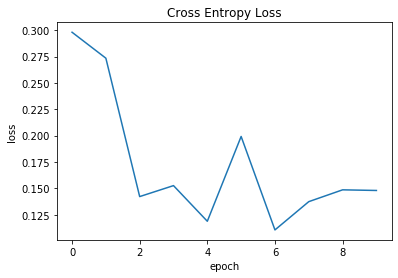

In [8]:
if __name__ == '__main__':
    
    start_time = time.time()
    #please, make sure you changed for your own path 
    log_files_path = 'D:/JupyterNotebook/IEOR_4742/HW2/logs/'

    with tf.Graph().as_default():
        
        with tf.variable_scope("multi_layer"):
            #neural network definition 
            
            #the input variables are first defined as placeholder 
            #a placeholder is a variable/data which will be assigned later 
            #image vector & label
            x = tf.placeholder("float", [None, input_size])   # MNIST data image of shape 28*28=784
            y = tf.placeholder("float", [None, output_size])  # 0-9 digits recognition

            #the network is defined using the inference function defined above in the code
            output = inference(x)

            cost = loss_2(output, y)
            
            #initialize the value of the global_step variable 
            # recall: it is incremented by one each time the .minimise() is called
            global_step = tf.Variable(0, name='global_step', trainable=False)
            
            train_op = training(cost, global_step)
            #train_op = training(cost, global_step=None)
            
            #evaluate the accuracy of the network (done on a validation set)
            eval_op = evaluate(output, y)

            summary_op = tf.summary.merge_all()
    
            #save and restore variables to and from checkpoints.
            saver = tf.train.Saver()
    
            #defines a session
            sess = tf.Session()
            
            # summary writer
            #https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter
            #
            summary_writer = tf.summary.FileWriter(log_files_path+'multi_layer/', sess.graph)
        
            #initialization of all the variables
            init_op = tf.global_variables_initializer()
            sess.run(init_op)
        
            #will work with this later
            #saver.restore(sess, log_files_path+'multi_layer/model-checkpoint-66000')
            
            loss_trace = []

            # Training cycle
            for epoch in range(training_epochs):

                avg_cost = 0.
                total_batch = int(mnist.train.num_examples/batch_size)
            
                # Loop over all batches
                for i in range(total_batch):

                    minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
                    
                    # Fit training using batch data
                    #the training is done using the training dataset
                    sess.run(train_op, feed_dict={x: minibatch_x, y: minibatch_y})
                    
                    # Compute average loss
                    avg_cost += sess.run(cost, feed_dict={x: minibatch_x, y: minibatch_y})/total_batch
                    
                # Display logs per epoch step
                if epoch % display_step == 0:
                    
                    #the accuracy is evaluated using the validation dataset
                    accuracy = sess.run(eval_op, feed_dict={x: mnist.validation.images, y: mnist.validation.labels})
                    loss_trace.append(1-accuracy)    
                    print("Epoch:", '%03d' % epoch, "cost function=", "{:0.7f}".format(avg_cost), " Validation Error:", (1.0 - accuracy))
                    summary_str = sess.run(summary_op, feed_dict={x: minibatch_x, y: minibatch_y})
                    summary_writer.add_summary(summary_str, sess.run(global_step))
                        
                    #save to use later
                    #https://www.tensorflow.org/api_docs/python/tf/train/Saver
                    #saver.save(sess, log_files_path+'model-checkpoint', global_step=global_step)
                    saver.save(sess, log_files_path + 'multi_layer/model-checkpoint', global_step=global_step)
                        
            print("Optimization Finished!")
            #accuracy evaluated with the whole test dataset
            accuracy = sess.run(eval_op, feed_dict={x: mnist.test.images, y: mnist.test.labels})
            print("Test Accuracy:", accuracy)
                    
            elapsed_time = time.time() - start_time
            print('Execution time (seconds) was %0.3f' % elapsed_time)
            
            # Visualization of the results
            # loss function
            plt.plot(loss_trace)
            plt.title('Cross Entropy Loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()